## Supernova distances and redshifts (part 1)

Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

Let's recall the definition of magnitude and the distance modulus (ah! the astronomers...)

$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$

####  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from astroML.datasets import generate_mu_z
import tqdm
import sklearn

plt.rcParams['figure.figsize']=(8,6) 
plt.rcParams['font.size']=18 
plt.rcParams['font.family']='Liberation Serif' 
plt.rcParams['figure.autolayout']=True 
plt.rcParams['mathtext.fontset'] = 'cm'

colors = ['palevioletred', 'mediumvioletred', 'darkmagenta', 'mediumblue', 'deepskyblue', 'forestgreen', 'limegreen', 'gold', 'orange', 'red']

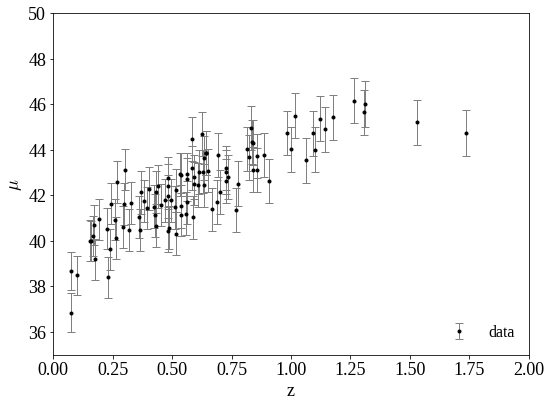

In [2]:
#generate the data samples and plot
z, mu, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z, mu, dmu, fmt='.k', ecolor='gray', lw=1,label='data', capsize = 4)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right', frameon=False, fontsize = 16)
plt.xlim(0,2)
plt.ylim(35,50)

#reshape the array of data
z_1 = z
z = z[:, np.newaxis]

## Linear regression

In [3]:
from sklearn.linear_model import LinearRegression # minimize the residual sum of squares between 
                                                  #the observed targets in the dataset, and the targets 
                                                  #predicted by the linear approximation

model_lin = LinearRegression()
model_lin.fit(z, mu, dmu)

LinearRegression()

(35.0, 50.0)

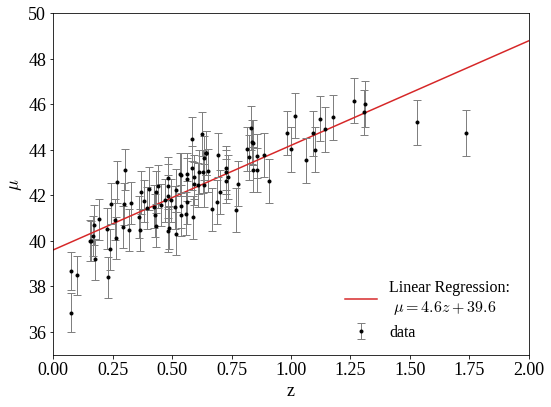

In [4]:
#draw the fit
x = np.linspace(0, 2, 1000)[:, np.newaxis]

ypred1 = model_lin.predict(x)
plt.plot(x, ypred1, color='tab:red', label='Linear Regression: \n $\mu = %.1f z + %.1f$' %tuple([model_lin.coef_, model_lin.intercept_]))

plt.errorbar(z, mu, dmu, fmt='.k', ecolor='gray', lw=1,label='data', capsize = 4)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right', frameon=False, fontsize = 16)
plt.xlim(0,2)
plt.ylim(35,50)

## Polynomial regression

(35.0, 50.0)

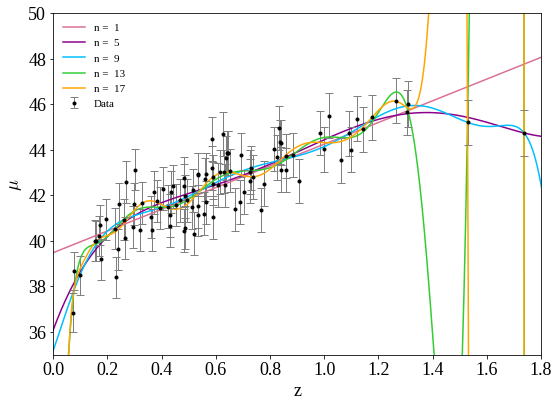

In [17]:
from astroML.linear_model import PolynomialRegression

N = np.linspace(1, 20, 20)
for n in N[::4]:
    model = PolynomialRegression(int(n))
    model.fit(z, mu, dmu)
    
    ypred2 = model.predict(x)    
    plt.plot(x, ypred2, color=colors[int(n/2)], label='n = % .f' % n)

plt.errorbar(z, mu, dmu, fmt='.k', ecolor='gray', lw=1, capsize = 4, label = 'Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(frameon = False, loc='upper left', fontsize = 11)
plt.xlim(0,1.8)
plt.ylim(35,50)

To determine the degree of the polynomium that best represent the data I must perform a cross-validation. This is performed on 5 different splits of the data in training set (80%) and validation set (20%)

In [6]:
#evaluate training and cross-validation rms
def rms(x, y, model):
    return np.sqrt(np.sum((y - model.predict(x))**2)/len(x))

n_split = 3    #number of splits
cv_size = len(z)/n_split
n_best = []    #array of best n evaluated
rms_train = np.zeros((n_split, len(N)))
rms_cv = np.zeros((n_split, len(N)))

for m in range(n_split):
    
    #build training and cross-validation set
    z_cv, mu_cv, dmu_cv = z[int(cv_size*m):int(cv_size*(m+1))], mu[int(cv_size*m):int(cv_size*(m+1))], dmu[int(cv_size*m):int(cv_size*(m+1))]
    indeces = np.arange(int(cv_size*m), int(cv_size*(m+1)), 1)
    z_train, mu_train, dmu_train = np.delete(z, indeces, axis = 0), np.delete(mu, indeces), np.delete(dmu, indeces)
    
    #cycle on the degree to evaluate the rms
    for n in N:
        model = PolynomialRegression(int(n))
        model.fit(z_train, mu_train, dmu_train) 

        rms_train[int(m), int(n-1)] = rms(z_train, mu_train, model)
        rms_cv[int(m), int(n-1)] = rms(z_cv, mu_cv, model)

    #find the best value of the degree minimizing the cross-validation rms
    n_best.append(N[np.argmin(rms_cv[m])])
    
    if np.any(z_cv > 1.6):
        a = 'Yes'
    else:
        a = 'No'
    if np.any(mu_cv < 37):
        b = 'Yes'
    else:
        b = 'No'
    print('split:', m, ', degree:', N[np.argmin(rms_cv[m])], ', the CV set contains the last point:', a, ', the CV set contains the first point:', b)

split: 0 , degree: 2.0 , the CV set contains the last point: No , the CV set contains the first point: No
split: 1 , degree: 2.0 , the CV set contains the last point: Yes , the CV set contains the first point: No
split: 2 , degree: 8.0 , the CV set contains the last point: No , the CV set contains the first point: Yes


It seems the first point is the one who makes the regression decrease quickly for $z>1.5$

The best fit degree is n =  2.0


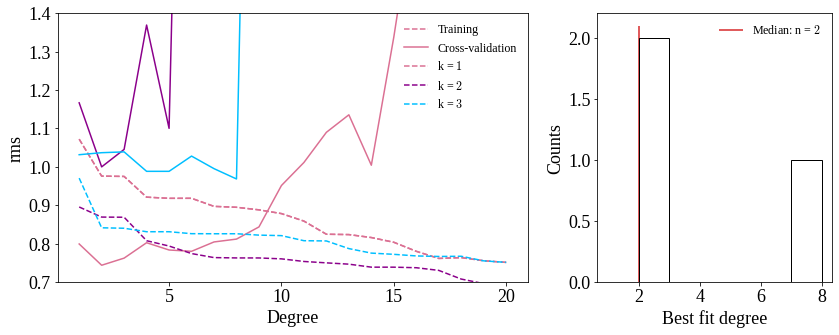

In [7]:
#plot
fig, ax = plt.subplots(1, 2, figsize = (12, 5), gridspec_kw={'width_ratios': [8, 4]})

#rms as a function of the degree
for m in range(n_split):
    if m == 0:
        ax[0].plot(N, rms_train[m], linestyle = '--', color = colors[int(2*m)], label = 'Training')
        ax[0].plot(N, rms_cv[m], linestyle = '-', color = colors[int(2*m)], label = 'Cross-validation')
        ax[0].plot(N, rms_train[m], linestyle = '--', color = colors[int(2*m)], label = 'k = $%.f$' %tuple([m+1]))
    else:
        ax[0].plot(N, rms_train[m], linestyle = '--', color = colors[int(2*m)], label = 'k = $%.f$' %tuple([m+1]))
        ax[0].plot(N, rms_cv[m], linestyle = '-', color = colors[int(2*m)])

ax[0].set_ylim([0.7, 1.4])
ax[0].legend(frameon = False, fontsize = 12, loc = 'upper right')
ax[0].set_xlabel('Degree')
ax[0].set_ylabel('rms')

#histograms of the values optained for the degree
ax[1].hist(n_best, bins = np.arange(1, 9, 1), histtype = 'step', color = 'k');
ax[1].vlines(x = np.median(n_best), ymin = 0, ymax = 2.1, color = 'tab:red', label = 'Median: n = $%.f$' %tuple([np.median(n_best)]))
ax[1].legend(frameon = False, fontsize = 12)
ax[1].set_xlabel('Best fit degree')
ax[1].set_ylabel('Counts')

#evaluate the best choice as the median
Best_n = np.median(n_best)
print('The best fit degree is n = ', Best_n)

/home/irene/.local/lib/python3.8/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


(35.0, 50.0)

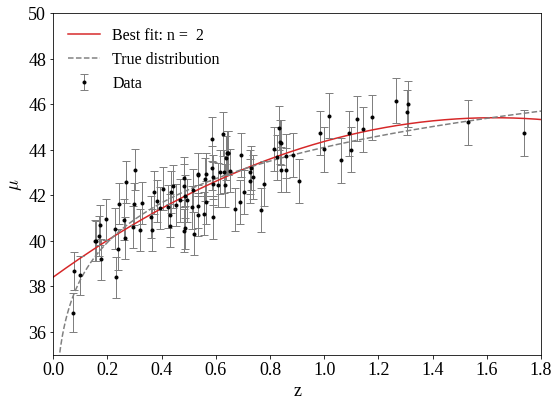

In [8]:
#perform the fit on the whole dataset to get the best parameters values
model = PolynomialRegression(int(Best_n))
model.fit(z, mu, dmu) 

ypred_poly = model.predict(x)    
plt.plot(x, ypred_poly, color='tab:red', label='Best fit: n = % .f' % Best_n)

from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=1-0.27)
mu_true = cosmo.distmod(x)

plt.plot(x, mu_true, '--', c='gray',label='True distribution')

plt.errorbar(z, mu, dmu, fmt='.k', ecolor='gray', lw=1, capsize = 4, label = 'Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(frameon = False, loc='upper left', fontsize = 16)
plt.xlim(0,1.8)
plt.ylim(35,50)

## Basis function regression

(35.0, 50.0)

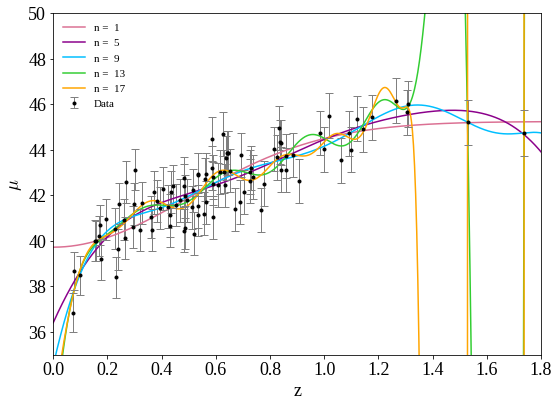

In [22]:
from astroML.linear_model import BasisFunctionRegression

for n in N[::4]:
    mu_grid = np.linspace(0, 2, int(n))[:, None]
    if n == 1:
        sigma_grid = 0.5
    else:
        sigma_grid = mu_grid[1] - mu_grid[0]
        
    model = BasisFunctionRegression('gaussian', mu=mu_grid, sigma=sigma_grid)
    model.fit(z, mu, dmu)
    
    ypred2 = model.predict(x)  
    plt.plot(x, ypred2, color=colors[int(n/2)], label='n = % .f' % n)

plt.errorbar(z, mu, dmu, fmt='.k', ecolor='gray', lw=1, capsize = 4, label = 'Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(frameon = False, loc='upper left', fontsize = 11)
plt.xlim(0,1.8)
plt.ylim(35,50)

In [10]:
N_best = []    #array of best n evaluated
rms_train = np.zeros((n_split, len(N)))
rms_cv = np.zeros((n_split, len(N)))

for m in range(n_split):
    
    #build training and cross-validation set
    z_cv, mu_cv, dmu_cv = z[int(cv_size*m):int(cv_size*(m+1))], mu[int(cv_size*m):int(cv_size*(m+1))], dmu[int(cv_size*m):int(cv_size*(m+1))]
    indeces = np.arange(int(cv_size*m), int(cv_size*(m+1)), 1)
    z_train, mu_train, dmu_train = np.delete(z, indeces, axis = 0), np.delete(mu, indeces), np.delete(dmu, indeces)

    #cycle on the degree to evaluate the rms
    for n in N:
        mu_grid = np.linspace(0, 2, int(n))[:, None]
        if n == 1:
            sigma_grid = 0.5
        else:
            sigma_grid = mu_grid[1] - mu_grid[0]

        model = BasisFunctionRegression('gaussian', mu=mu_grid, sigma=sigma_grid)
        model.fit(z_train, mu_train, dmu_train) 

        rms_train[int(m), int(n-1)] = rms(z_train, mu_train, model)
        rms_cv[int(m), int(n-1)] = rms(z_cv, mu_cv, model)

    #find the best value of the degree minimizing the cross-validation rms
    N_best.append(N[np.argmin(rms_cv[m])])
    
    mu_grid = np.linspace(0, 1.8, int(N[np.argmin(rms_cv[m])]))[:, None]
    if N[np.argmin(rms_cv[m])] == 1:
        sigma_grid = 0.5
    else:
        sigma_grid = mu_grid[1] - mu_grid[0]
    model = BasisFunctionRegression('gaussian', mu=mu_grid, sigma=sigma_grid)
    model.fit(z, mu, dmu) 

    ypred_gaus = model.predict(x)
    
    if np.any(z_cv > 1.6):
        a = 'Yes'
    else:
        a = 'No'
    if np.any(mu_cv < 37):
        b = 'Yes'
    else:
        b = 'No'
    print('split:', m, ', # of Gaussians:', N[np.argmin(rms_cv[m])], ', the CV set contains the last point:', a, ', the CV set contains the first point:', b)

split: 0 , # of Gaussians: 2.0 , the CV set contains the last point: No , the CV set contains the first point: No
split: 1 , # of Gaussians: 3.0 , the CV set contains the last point: Yes , the CV set contains the first point: No
split: 2 , # of Gaussians: 7.0 , the CV set contains the last point: No , the CV set contains the first point: Yes


The best fit number of components is n =  3.0


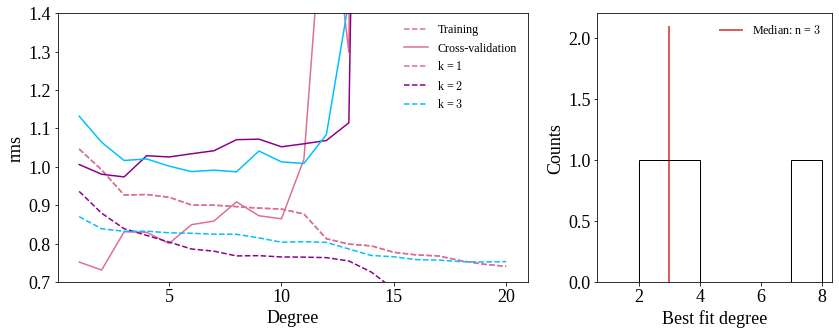

In [41]:
#plot
fig, ax = plt.subplots(1, 2, figsize = (12, 5), gridspec_kw={'width_ratios': [8, 4]})

#rms as a function of the degree
for m in range(n_split):
    if m == 0:
        ax[0].plot(N, rms_train[m], linestyle = '--', color = colors[int(2*m)], label = 'Training')
        ax[0].plot(N, rms_cv[m], linestyle = '-', color = colors[int(2*m)], label = 'Cross-validation')
        ax[0].plot(N, rms_train[m], linestyle = '--', color = colors[int(2*m)], label = 'k = $%.f$' %tuple([m+1]))
    else:
        ax[0].plot(N, rms_train[m], linestyle = '--', color = colors[int(2*m)], label = 'k = $%.f$' %tuple([m+1]))
        ax[0].plot(N, rms_cv[m], linestyle = '-', color = colors[int(2*m)])

ax[0].set_ylim([0.7, 1.4])
ax[0].legend(frameon = False, fontsize = 12, loc = 'upper right')
ax[0].set_xlabel('Degree')
ax[0].set_ylabel('rms')

#histograms of the values optained for the degree
ax[1].hist(N_best, bins = np.arange(1, 9, 1), histtype = 'step', color = 'k');
ax[1].vlines(x = np.median(N_best), ymin = 0, ymax = 2.1, color = 'tab:red', label = 'Median: n = $%.f$' %tuple([np.median(N_best)]))
ax[1].legend(frameon = False, fontsize = 12)
ax[1].set_xlabel('Best fit degree')
ax[1].set_ylabel('Counts')

#evaluate the best choice as the median
Best_N = np.median(N_best)
print('The best fit number of components is n = ', Best_N)

(35.0, 50.0)

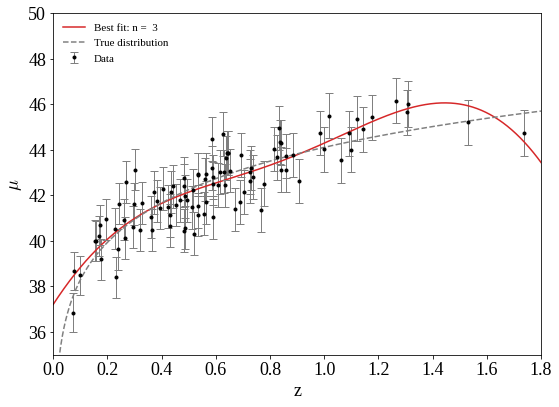

In [24]:
#perform the fit on the whole dataset to get the best parameters values
mu_grid = np.linspace(0, 1.8, int(Best_N))[:, None]
sigma_grid = mu_grid[1] - mu_grid[0]
model = BasisFunctionRegression('gaussian', mu=mu_grid, sigma=sigma_grid)
model.fit(z, mu, dmu) 

ypred_gaus = model.predict(x)    
plt.plot(x, ypred_gaus, color='tab:red', label='Best fit: n = % .f' % Best_N)

plt.plot(x, mu_true, '--', c='gray',label='True distribution')
plt.errorbar(z, mu, dmu, fmt='.k', ecolor='gray', lw=1, capsize = 4, label = 'Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(frameon = False, loc='upper left', fontsize = 11)
plt.xlim(0,1.8)
plt.ylim(35,50)

## Kernel regression

(35.0, 50.0)

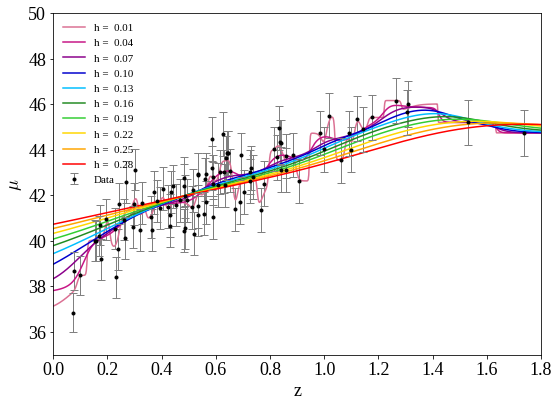

In [25]:
from astroML.linear_model import NadarayaWatson
H = np.linspace(0.01, 0.3, 20)
n = 0
for h in H[::2]:
    
    model = NadarayaWatson(kernel='gaussian', h=h)
    model.fit(z, mu, dmu)
    
    ypred2 = model.predict(x)  
    plt.plot(x, ypred2, color=colors[int(n/2)], label='h = % .2f' % h)
    n += 2
    
plt.errorbar(z, mu, dmu, fmt='.k', ecolor='gray', lw=1, capsize = 4, label = 'Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(frameon = False, loc='upper left', fontsize = 11)
plt.xlim(0,1.8)
plt.ylim(35,50)

In [29]:
h_best = []    #array of best n evaluated
N_sampling = 100  #how many values of h to prove
H = np.logspace(-2, 1, N_sampling)
rms_train = np.zeros((n_split, N_sampling))
rms_cv = np.zeros((n_split, N_sampling))

for m in range(n_split):
    
    #build training and cross-validation set
    z_cv, mu_cv, dmu_cv = z[int(cv_size*m):int(cv_size*(m+1))], mu[int(cv_size*m):int(cv_size*(m+1))], dmu[int(cv_size*m):int(cv_size*(m+1))]
    indeces = np.arange(int(cv_size*m), int(cv_size*(m+1)), 1)
    z_train, mu_train, dmu_train = np.delete(z, indeces, axis = 0), np.delete(mu, indeces), np.delete(dmu, indeces)
    
    #cycle on the degree to evaluate the rms
    n = 1
    for h in H:
        model = NadarayaWatson(kernel='gaussian', h=h)
        model.fit(z_train, mu_train, dmu_train) 

        rms_train[int(m), int(n-1)] = rms(z_train, mu_train, model)
        rms_cv[int(m), int(n-1)] = rms(z_cv, mu_cv, model)
        n+=1
        
    #find the best value of the degree minimizing the cross-validation rms
    h_best.append(H[np.argmin(rms_cv[m])])

The best fit degree is n =  0.049770235643321115


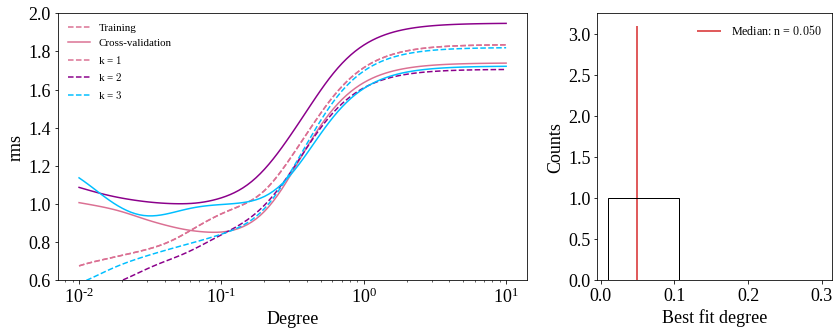

In [30]:
#plot
fig, ax = plt.subplots(1, 2, figsize = (12, 5), gridspec_kw={'width_ratios': [8, 4]})

#rms as a function of the degree
for m in range(n_split):
    if m == 0:
        ax[0].plot(H, rms_train[m], linestyle = '--', color = colors[int(2*m)], label = 'Training')
        ax[0].plot(H, rms_cv[m], linestyle = '-', color = colors[int(2*m)], label = 'Cross-validation')
        ax[0].plot(H, rms_train[m], linestyle = '--', color = colors[int(2*m)], label = 'k = $%.f$' %tuple([m+1]))
    else:
        ax[0].plot(H, rms_train[m], linestyle = '--', color = colors[int(2*m)], label = 'k = $%.f$' %tuple([m+1]))
        ax[0].plot(H, rms_cv[m], linestyle = '-', color = colors[int(2*m)])

ax[0].set_ylim([0.6, 2])
ax[0].set_xscale('log')
ax[0].legend(frameon = False, fontsize = 11, loc = 'upper left')
ax[0].set_xlabel('Degree')
ax[0].set_ylabel('rms')

#histograms of the values optained for the degree
ax[1].hist(h_best, bins = np.linspace(0.01, 0.3, 10), histtype = 'step', color = 'k');
ax[1].vlines(x = np.median(h_best), ymin = 0, ymax = 3.1, color = 'tab:red', label = 'Median: n = $%.3f$' %tuple([np.median(h_best)]))
ax[1].legend(frameon = False, fontsize = 12)
ax[1].set_xlabel('Best fit degree')
ax[1].set_ylabel('Counts')

#evaluate the best choice as the median
Best_h = np.median(h_best)
print('The best fit degree is n = ', Best_h)

(35.0, 50.0)

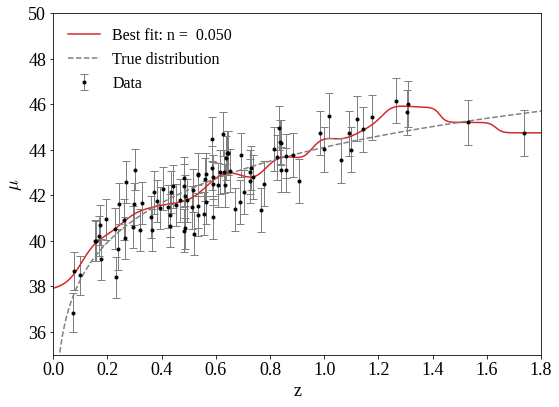

In [31]:
#perform the fit on the whole dataset to get the best parameters values
model = NadarayaWatson(kernel='gaussian', h=Best_h)
model.fit(z, mu, dmu) 

ypred_kernel = model.predict(x)    
plt.plot(x, ypred_kernel, color='tab:red', label='Best fit: n = % .3f' % Best_h)

plt.plot(x, mu_true, '--', c='gray',label='True distribution')
plt.errorbar(z, mu, dmu, fmt='.k', ecolor='gray', lw=1, capsize = 4, label = 'Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(frameon = False, loc='upper left', fontsize = 16)
plt.xlim(0,1.8)
plt.ylim(35,50)

## Comparison of the 3 fits

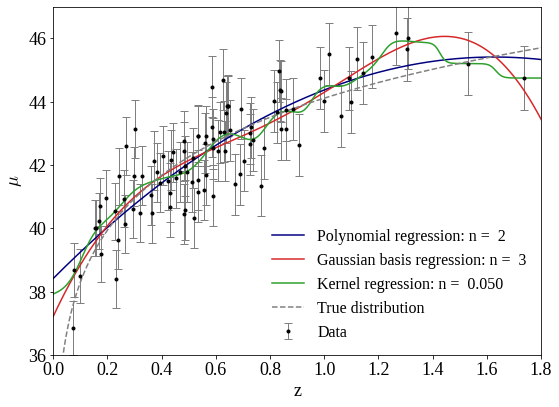

In [32]:
#data
plt.errorbar(z, mu, dmu, fmt='.k', ecolor='gray', lw=1, capsize = 4, label = 'Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(frameon = False, loc='upper left', fontsize = 16)
plt.xlim(0,1.8)
plt.ylim(36,47)

#models
plt.plot(x, ypred_poly, color='navy', label='Polynomial regression: n = % .f' % Best_n)
plt.plot(x, ypred_gaus, color='tab:red', label='Gaussian basis regression: n = % .f' % Best_N)
plt.plot(x, ypred_kernel, color='tab:green', label='Kernel regression: n = % .3f' % Best_h)

plt.plot(x, mu_true, '--', c='gray',label='True distribution')
plt.legend(frameon = False, fontsize = 16)

## Learning curves

In [33]:
from sklearn.model_selection import train_test_split

z_train_aux, z_cv, mudmu_train, mudmu_cv = train_test_split(z, np.array([mu,dmu]).T, test_size=0.3, random_state = 42)
mu_train_aux,dmu_train_aux = mudmu_train.T
mu_cv,dmu_cv = mudmu_cv.T
Max = np.arange(2, 72, 2)
print('Training set sizes:', Max)
rms_train_poly, rms_cv_poly, rms_train_gaus, rms_cv_gaus, rms_train_kernel, rms_cv_kernel = [], [], [], [], [], [] 

for Range in Max:
    z_train = z_train_aux[:Range]
    mu_train = mu_train_aux[:Range]
    dmu_train = dmu_train_aux[:Range]
    
    #Polynomial model
    model = PolynomialRegression(int(Best_n))
    model.fit(z_train, mu_train, dmu_train) 
    rms_train_poly.append(rms(z_train, mu_train, model))
    rms_cv_poly.append(rms(z_cv, mu_cv, model))

    #Basis function regression
    mu_grid = np.linspace(0, 1.8, int(Best_N))[:, None]
    sigma_grid = mu_grid[1] - mu_grid[0]
    model = BasisFunctionRegression('gaussian', mu=mu_grid, sigma=sigma_grid)
    model.fit(z_train, mu_train, dmu_train) 
    rms_train_gaus.append(rms(z_train, mu_train, model))
    rms_cv_gaus.append(rms(z_cv, mu_cv, model))
    
    #Kernel regression
    model = NadarayaWatson(kernel='gaussian', h=Best_h)
    model.fit(z_train, mu_train, dmu_train) 
    rms_train_kernel.append(rms(z_train, mu_train, model))
    rms_cv_kernel.append(rms(z_cv, mu_cv, model))

Training set sizes: [ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48
 50 52 54 56 58 60 62 64 66 68 70]


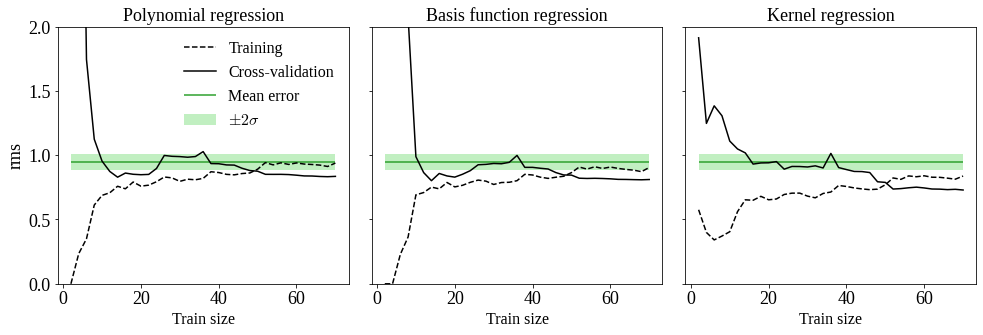

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
ax[0].plot(Max, rms_train_poly, color = 'k', linestyle = '--', label = 'Training')
ax[0].plot(Max, rms_cv_poly, color = 'k', linestyle = '-', label = 'Cross-validation')
ax[0].set_ylim(0, 2)
ax[0].set_title('Polynomial regression', fontsize=18)
ax[0].set_xlabel('Train size', fontsize=16)
ax[0].set_ylabel('rms')

ax[1].plot(Max, rms_train_gaus, color = 'k', linestyle = '--')
ax[1].plot(Max, rms_cv_gaus, color = 'k', linestyle = '-')
ax[1].set_ylim(0, 2)
ax[1].set_title('Basis function regression', fontsize=18)
ax[1].set_xlabel('Train size', fontsize=16)

ax[2].plot(Max, rms_train_kernel, color = 'k', linestyle = '--')
ax[2].plot(Max, rms_cv_kernel, color = 'k', linestyle = '-')
ax[2].set_ylim(0, 2)
ax[2].set_title('Kernel regression', fontsize=18)
ax[2].set_xlabel('Train size', fontsize=16)

ax[0].hlines(y=np.mean(dmu), xmin=np.min(Max), xmax=np.max(Max), color='tab:green', label='Mean error')
ax[0].fill_between(Max, np.mean(dmu)-2*np.std(dmu), np.mean(dmu)+2*np.std(dmu), alpha=0.3, color='limegreen', edgecolor=None, label='$\pm2\sigma$')
ax[1].hlines(y=np.mean(dmu), xmin=np.min(Max), xmax=np.max(Max), color='tab:green', label='Mean error')
ax[1].fill_between(Max, np.mean(dmu)-2*np.std(dmu), np.mean(dmu)+2*np.std(dmu), alpha=0.3, color='limegreen', edgecolor=None)
ax[2].hlines(y=np.mean(dmu), xmin=np.min(Max), xmax=np.max(Max), color='tab:green', label='Mean error')
ax[2].fill_between(Max, np.mean(dmu)-2*np.std(dmu), np.mean(dmu)+2*np.std(dmu), alpha=0.3, color='limegreen', edgecolor=None)

ax[0].legend(frameon=False, fontsize=16)

Now re-do the basis function regression without the first or without the last data point to see if one of the two is the reason for the unexpected decrease of the fitting function above redshift 1.5

(36.0, 47.0)

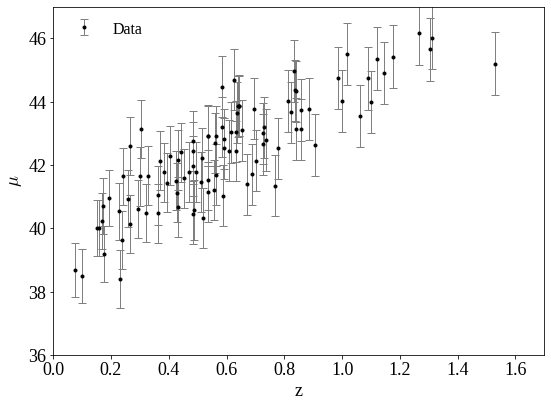

In [48]:
z_new1 = z[z_1 < 1.5]
mu_new1 = mu[z_1 < 1.5]
dmu_new1 = dmu[z_1 < 1.5]
z_new2 = z[mu > 37]
mu_new2 = mu[mu > 37]
dmu_new2 = dmu[mu > 37]

plt.errorbar(z_new, mu_new, dmu_new, fmt='.k', ecolor='gray', lw=1, capsize = 4, label = 'Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(frameon = False, loc='upper left', fontsize = 16)
plt.xlim(0,1.7)
plt.ylim(36,47)

In [49]:
Best_N = []
for z_new, mu_new, dmu_new in zip([z_new1, z_new2], [mu_new1, mu_new2], [dmu_new1, dmu_new2]):
    N_best = []    #array of best n evaluated
    rms_train = np.zeros((n_split, len(N)))
    rms_cv = np.zeros((n_split, len(N)))

    for m in range(n_split):

        #build training and cross-validation set
        if m == n_split-1:
            z_cv, mu_cv, dmu_cv = z_new[int(cv_size*m):len(z_new)], mu_new[int(cv_size*m):len(z_new)], dmu_new[int(cv_size*m):len(z_new)]
            indeces = np.arange(int(cv_size*m), len(z_new), 1)
        else:
            z_cv, mu_cv, dmu_cv = z_new[int(cv_size*m):int(cv_size*(m+1))], mu_new[int(cv_size*m):int(cv_size*(m+1))], dmu_new[int(cv_size*m):int(cv_size*(m+1))]
            indeces = np.arange(int(cv_size*m), int(cv_size*(m+1)), 1)

        z_train, mu_train, dmu_train = np.delete(z_new, indeces, axis = 0), np.delete(mu_new, indeces), np.delete(dmu_new, indeces)

        #cycle on the degree to evaluate the rms
        for n in N:
            mu_grid = np.linspace(0, 2, int(n))[:, None]
            if n == 1:
                sigma_grid = 0.5
            else:
                sigma_grid = mu_grid[1] - mu_grid[0]

            model = BasisFunctionRegression('gaussian', mu=mu_grid, sigma=sigma_grid)
            model.fit(z_train, mu_train, dmu_train) 

            rms_train[int(m), int(n-1)] = rms(z_train, mu_train, model)
            rms_cv[int(m), int(n-1)] = rms(z_cv, mu_cv, model)

        #find the best value of the degree minimizing the cross-validation rms
        N_best.append(N[np.argmin(rms_cv[m])])

        if np.any(z_cv > 1.6):
            a = 'Yes'
        else:
            a = 'No'
        if np.any(mu_cv < 37):
            b = 'Yes'
        else:
            b = 'No'
        print('split:', m, ', # of Gaussians:', N[np.argmin(rms_cv[m])], ', the CV set contains the last point:', a, ', the CV set contains the first point:', b)
        
    Best_N.append(np.median(N_best))
    
print(Best_N)

split: 0 , # of Gaussians: 2.0 , the CV set contains the last point: No , the CV set contains the first point: No
split: 1 , # of Gaussians: 3.0 , the CV set contains the last point: No , the CV set contains the first point: No
split: 2 , # of Gaussians: 8.0 , the CV set contains the last point: No , the CV set contains the first point: Yes
split: 0 , # of Gaussians: 2.0 , the CV set contains the last point: No , the CV set contains the first point: No
split: 1 , # of Gaussians: 1.0 , the CV set contains the last point: Yes , the CV set contains the first point: No
split: 2 , # of Gaussians: 7.0 , the CV set contains the last point: No , the CV set contains the first point: No
[3.0, 2.0]


(1000,) (1000,)


<ipython-input-55-e38fbcf82b38>:30: RuntimeWarning: invalid value encountered in subtract
  ax[1].plot(x, mu_true - mu_true, '--', c='gray')


Text(0.5, 0, 'z')

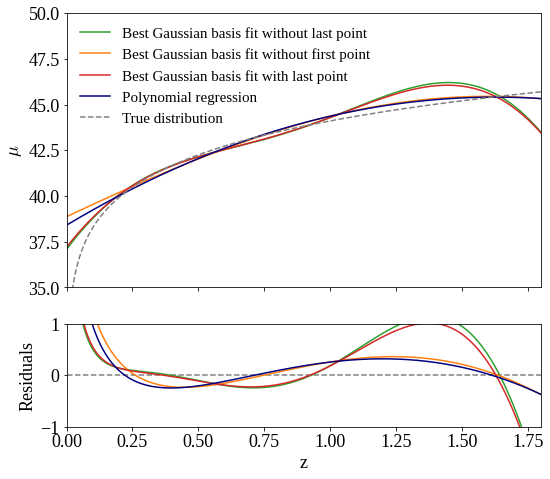

In [55]:
fig, ax = plt.subplots(2, 1, figsize = (8, 7), gridspec_kw={'height_ratios': [8, 3]}, sharex = True)

#perform the fit on the whole dataset to get the best parameters values
mu_grid = np.linspace(0, 1.8, int(Best_N[0]))[:, None]
sigma_grid = mu_grid[1] - mu_grid[0]
model = BasisFunctionRegression('gaussian', mu=mu_grid, sigma=sigma_grid)
model.fit(z_new1, mu_new1, dmu_new1) 
ypred_gaus1 = model.predict(x)  

mu_grid = np.linspace(0, 1.8, int(Best_N[1]))[:, None]
sigma_grid = mu_grid[1] - mu_grid[0]
model = BasisFunctionRegression('gaussian', mu=mu_grid, sigma=sigma_grid)
model.fit(z_new2, mu_new2, dmu_new2) 
ypred_gaus2 = model.predict(x)  

ax[0].plot(x, ypred_gaus1, color='tab:green', label='Best Gaussian basis fit without last point')
ax[0].plot(x, ypred_gaus2, color='tab:orange', label='Best Gaussian basis fit without first point')
ax[0].plot(x, ypred_gaus, color='tab:red', label='Best Gaussian basis fit with last point')
ax[0].plot(x, ypred_poly, color='navy', label='Polynomial regression')
ax[0].plot(x, mu_true, '--', c='gray',label='True distribution')

#ax[0].errorbar(z_new, mu_new, dmu_new, fmt='.k', ecolor='gray', lw=1, capsize = 4, label = 'Data')
ax[0].set_ylabel("$\mu$")
ax[0].legend(frameon = False, loc='upper left', fontsize = 15)
ax[0].set_xlim(0,1.8)
ax[0].set_ylim(35,50)

mu_true = np.array(mu_true.reshape(len(mu_true)))
print(ypred_gaus1.shape, mu_true.shape)
ax[1].plot(x, mu_true - mu_true, '--', c='gray')
ax[1].plot(x, ypred_gaus1-mu_true, color='tab:green')
ax[1].plot(x, ypred_gaus2-mu_true, color='tab:orange')
ax[1].plot(x, ypred_gaus-mu_true, color='tab:red')
ax[1].plot(x, ypred_poly-mu_true, color='navy')
ax[1].set_ylabel('Residuals')
ax[1].set_ylim(-1, 1)
ax[1].set_xlabel("z")